In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from MaskedRNN import MaskedDeepGRU
from loaders import data_loaders

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.figsize': (15, 8)})
sns.set_style('darkgrid')
sns.set_palette('deep')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

#### Parameters

In [0]:
MODEL = 'gru'

In [0]:
BATCH_SIZE = 16

INPUT_SIZE = 128
EMBEDDING_DIM = 100
OUTPUT_SIZE = 2

HIDDEN_LAYERS = [50, 50, 50]

#### DataLoader

In [0]:
train_loader, test_loader = data_loaders(BATCH_SIZE)

#### Helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor.to(device))

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Model

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers: list):
        super(Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layers[0]).to(device)
        self.recurrent = MaskedDeepGRU(hidden_layers[0], hidden_layers).to(device)
        self.fc = nn.Linear(hidden_layers[-1], output_size).to(device)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)
        output = self.recurrent(embedded)
        return self.fc(output)

#### Train & Test

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def test():
    correct = 0.
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct / test_data_size
    return acc

#### Pruning

In [0]:
pruned_perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pruned_acc = []

In [0]:
model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS)

In [17]:
param_dict = torch.load('gru-dict.pt')
model.load_state_dict(param_dict)

<All keys matched successfully>

In [18]:
for perc in pruned_perc:
    print('Pruned {}%'.format(perc))
    model.recurrent.set_mask(perc)
    acc = test()
    print('Accuracy: {:.2f}%\n'.format(acc))
    pruned_acc.append(acc)

Pruned 10%
Accuracy: 100.00%

Pruned 20%
Accuracy: 100.00%

Pruned 30%
Accuracy: 100.00%

Pruned 40%
Accuracy: 100.00%

Pruned 50%
Accuracy: 100.00%

Pruned 60%
Accuracy: 100.00%

Pruned 70%
Accuracy: 100.00%

Pruned 80%
Accuracy: 100.00%

Pruned 90%
Accuracy: 50.54%

Pruned 100%
Accuracy: 50.58%



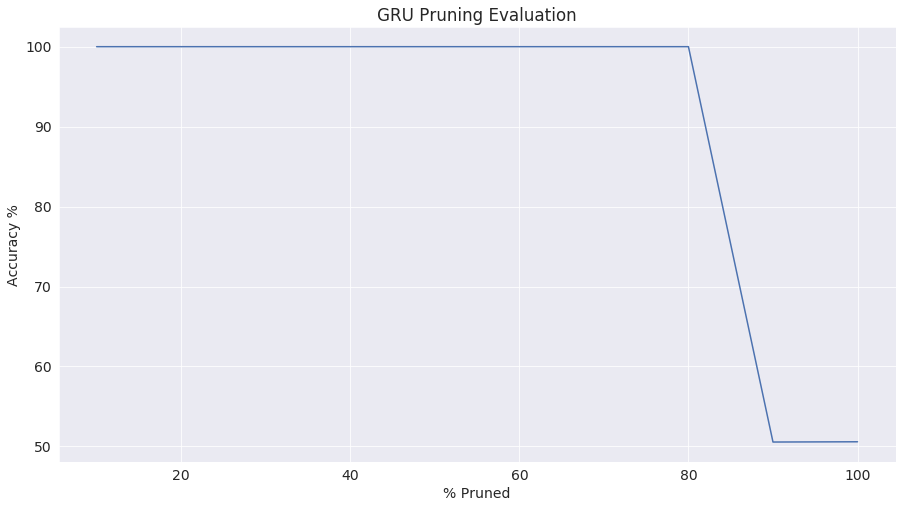

In [29]:
plt.title('{} Pruning Evaluation'.format(MODEL.upper()))
plt.xlabel('% Pruned')
plt.ylabel('Accuracy %')
plt.savefig('./accuracies/{}-pruning-accuracy.png'.format(MODEL))
plt.plot(pruned_perc, pruned_acc);

In [0]:
with open('./accuracies/{}-pruning-accuracies.txt'.format(MODEL), 'a') as f:
    f.write('{}'.format(MODEL.upper()) + ':' + ','.join(str(a.item()) for a in pruned_acc) + '\n')

#### Re-train

In [0]:
regain_after = [90, 100]
regain_accs = []

In [22]:
%%time
for perc in regain_after:
    model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS)
    model.load_state_dict(param_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print('Pruned {}%\n{}'.format(perc, '-'*12))
    model.recurrent.set_mask(perc)

    base_acc = test()

    acc = [base_acc]
    for e in range(6):
        print('Epoch {}: {:.2f}%'.format(e, base_acc))
        train()
        base_acc = test()
        acc.append(base_acc)

    regain_accs.append(acc)
    print('\n')

Pruned 90%
------------
Epoch 0: 50.77%
Epoch 1: 100.00%
Epoch 2: 100.00%
Epoch 3: 100.00%
Epoch 4: 100.00%
Epoch 5: 100.00%


Pruned 100%
------------
Epoch 0: 50.58%
Epoch 1: 49.42%
Epoch 2: 50.58%
Epoch 3: 50.58%
Epoch 4: 50.58%
Epoch 5: 49.42%


CPU times: user 18min 45s, sys: 1.22 s, total: 18min 47s
Wall time: 18min 50s


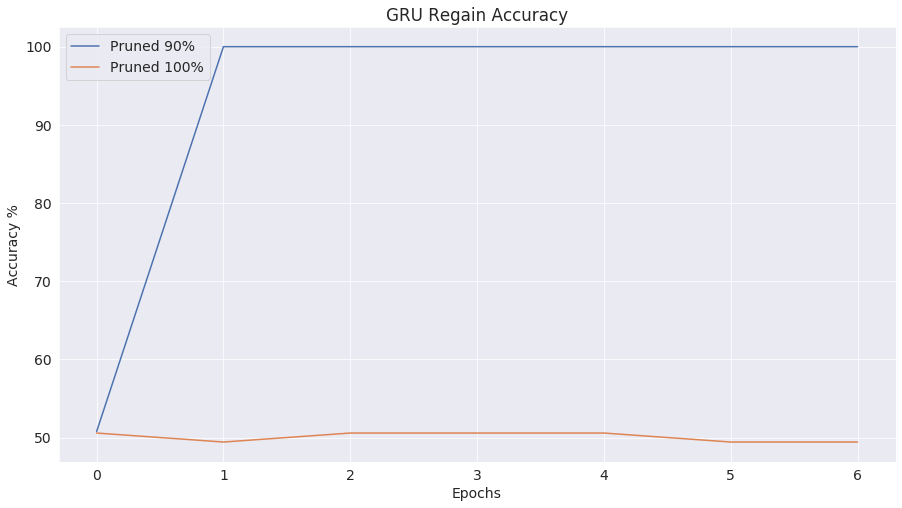

In [28]:
plt.title('{} Regain Accuracy'.format(MODEL.upper()))
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
for i, perc in enumerate(regain_after):
    plt.plot(regain_accs[i], label='Pruned {}%'.format(perc))
plt.legend()
plt.savefig('./accuracies/{}-regain-accuracy.png'.format(MODEL))

In [0]:
write_line = ''

In [0]:
for i, a in enumerate(regain_accs):
    write_line += '{}%'.format(regain_after[i]) + ':' + ','.join(str(_a.item()) for _a in a) + '\n'

In [0]:
with open('./accuracies/{}-regain-accuracies.txt'.format(MODEL), 'a') as f:
    f.write(write_line)